# Exercise 1: Convolutional Neural Networks for Image Classification

@ Vusal Isayev

The image shows that we feed an image as an input to the network, which goes through multiple convolutions, subsampling, a fully connected layer and finally outputs something.

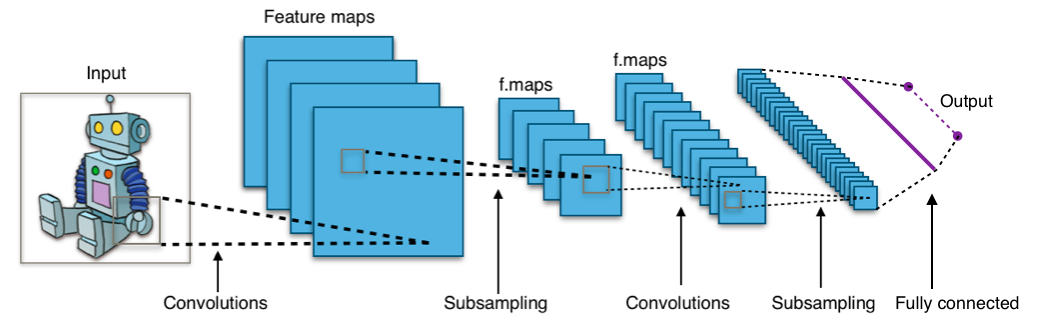

1.The convolution layer computes the output of neurons that are connected to local regions or receptive fields in the input, each computing a dot product between their weights and a small receptive field to which they are connected to in the input volume. Each computation leads to extraction of a feature map from the input image. 

2.The objective of subsampling is to get an input representation by reducing its dimensions, which helps in reducing overfitting. One of the techniques of subsampling is max pooling. With this technique, we select the highest pixel value from a region depending on its size. 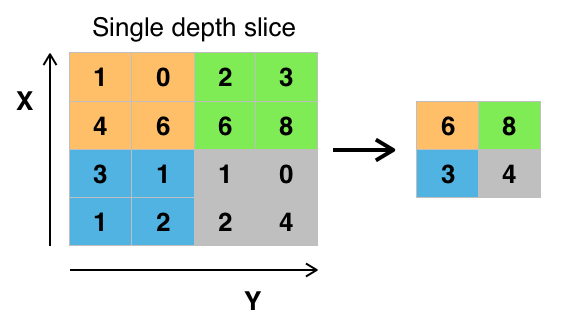

3.The objective of the fully connected layer is to flatten the high-level features that are learned by convolutional layers and combining all the features. It passes the flattened output to the output layer where you use a softmax classifier or a sigmoid to predict the input class label.

Now after some basic info lets go ahead and load our CIFAR10 data.

I will use Keras because of being possible to download directly to server instead of download data to laptop, it comes with 163 mb . Keras comes with a library called datasets, which we can use to load datasets out of the box.

The train and test images along with the labels are loaded and stored in variables train_X, train_Y, test_X, test_Y, respectively.

In [15]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [16]:
# Let's analyze how images in the dataset look like
# as we know pictures should have dimension of 32*32*3 lets see it
# 50000 train and 10000 test examples

import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

(train_X,train_Y), (test_X,test_Y) = cifar10.load_data()

print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)


In [17]:
# Here are the classes in the dataset.
# airplane , automobile, dog, horse, frog, bird, cat, deer ship and truck are 10 classes of our dataset.

classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5,1,'Ground Truth : [3]')

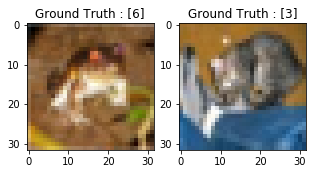

In [18]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

The output of above two plots looks like frog and dog, and classes are assigned a class label of 6 and 3 respectively.

In [20]:
# Data Preprocessing
# The data right now is in an int8 format, so before you feed it into the network you need to convert its type to float32
# We also have to rescale the pixel values in range 0 - 1 inclusive.

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In one-hot encoding, we convert the categorical data into a vector of numbers. The reason why we convert the categorical data in one hot encoding is that machine learning algorithms cannot work with categorical data directly. We generate one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample. Hence, the term one-hot encoding.

In [22]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: [6]
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [23]:
# So let's convert the training and testing labels into one-hot encoding vectors:

from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

For the model to generalize well, we split the training data into two parts, one designed for training and another one for validation. In this case, we will train the model on 80% of the training data and validate it on 20% of the remaining training data. This will also help to reduce overfitting since we will be validating the model on the data it would not have seen in training phase, which will help in boosting the test performance.

In [34]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 10), (10000, 10))

The Network will be:
    
    1. conv1: convolution and rectified linear activation (RELU)
    2. pool1: max pooling
    3. FC2: fully connected layer with rectified linear activation (RELU)
    4. softmax layer: final output predictions i.e. classify into one of the ten classes.



In [35]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [48]:
#i will use a batch size of 64 using a higher batch size of 128 or 256 is also good it all depends on the memory but by using batch size more my laptop becomes and performs slower. 
#I will train the network for 20 epochs. Again for better results we can do it with epoch size 100, more epoch accuracy will be better.

batch_size = 64
epochs = 20
num_classes = 10

# Neural Network Architecture

i will add firstly convolutional layer with Conv2D(). Note that i'm using this function because i'm working with images. Next, i add the Leaky ReLU activation function which helps the network learn non-linear decision boundaries. Since i have ten different classes, i need a non-linear decision boundary that could separate these ten classes which are not linearly separable.

Why Leaky Relu? Leaky ReLUs because they attempt to fix the problem of dying Rectified Linear Units (ReLUs). The ReLU function allows the activation to be thresholded at zero. However, during the training, ReLU units can "die". This can happen when a large gradient flows through a ReLU neuron: it can cause the weights to update in such a way that the neuron will never activate on any data point again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. Leaky ReLUs attempt to solve this: the function will not be zero but will instead have a small negative slope.

Next, i will add the max-pooling layer with MaxPooling2D() and so on. The last layer is a Dense layer that has a softmax activation function with 10 units, which is needed for this multi-class classification problem.

In [42]:
cifar_model = Sequential()
cifar_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))
cifar_model.add(LeakyReLU(alpha=0.1))
cifar_model.add(MaxPooling2D((2, 2),padding='same'))
cifar_model.add(Flatten())
cifar_model.add(Dense(32, activation='linear'))
cifar_model.add(LeakyReLU(alpha=0.1))                  
cifar_model.add(Dense(num_classes, activation='softmax'))

Compile the Model

After the model is created, i compile it using the Adam optimizer. Additionally, i specify the loss type which is categorical cross entropy which is used for multi-class classification. Lastly, i specify the metrics as accuracy which i want to analyze while the model is training.

In [43]:
cifar_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [44]:
# Showing some parameters (weights and biases) in each layer and also the total parameters in our model by summarizing.

cifar_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                262176    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total para

In [45]:
# Train the Model
# Finally training the model with Keras' fit() function! The model trains for 20 epochs. 
# The fit() function will return a history object; By storying the result of this function in digar_train.

cifar_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 87s 2ms/step - loss: 1.0645 - acc: 0.6269 - val_loss: 1.1545 - val_acc: 0.5945
Epoch 2/20
40000/40000 [==============================] - 85s 2ms/step - loss: 0.9918 - acc: 0.6529 - val_loss: 1.0938 - val_acc: 0.6151
Epoch 3/20
40000/40000 [==============================] - 84s 2ms/step - loss: 0.9311 - acc: 0.6735 - val_loss: 1.0801 - val_acc: 0.6261
Epoch 4/20
40000/40000 [==============================] - 87s 2ms/step - loss: 0.8690 - acc: 0.6954 - val_loss: 1.0511 - val_acc: 0.6387
Epoch 5/20
40000/40000 [==============================] - 88s 2ms/step - loss: 0.8155 - acc: 0.7154 - val_loss: 1.0862 - val_acc: 0.6266
Epoch 6/20
40000/40000 [==============================] - 88s 2ms/step - loss: 0.7724 - acc: 0.7290 - val_loss: 1.0789 - val_acc: 0.6361
Epoch 7/20
40000/40000 [==============================] - 88s 2ms/step - loss: 0.7268 - acc: 0.7440 - val_loss: 1.0689 - val_acc

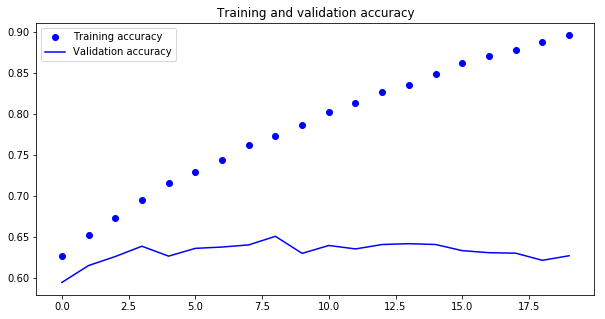

In [57]:
accuracy = cifar_train.history['acc']
val_accuracy = cifar_train.history['val_acc']
loss = cifar_train.history['loss']
val_loss = cifar_train.history['val_loss']
epochs = range(len(accuracy))
plt.figure(figsize=[10,5])
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

We can see that the validation accuracy almost became immovable after 3 epochs and rarely increased at certain epochs. The maximum point of increasement was at epoch 8. In the beginning, the validation accuracy was linearly increasing with loss, but then it did not increase much.

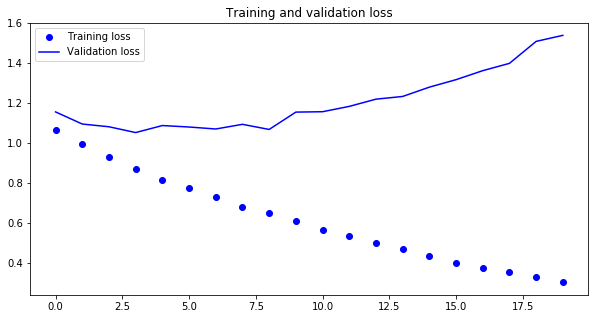

In [58]:
plt.figure(figsize=[10,5])
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

 Similar to validation accuracy validation loss linearly decreased till 3 then it was stagnant from 3 to 8 but after it started to increase. This means that the model tried to memorize the data and succeeded.